# Build a CNN model

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tools import pretraitement
import random
import os
import json
import sys
import time

2021-12-08 18:23:27.234020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 18:23:27.234046: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Chargement du jeu de données
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = tf.keras.datasets.cifar10.load_data()

# pretraitement des données
(x_train, y_train) = pretraitement.normalize_dataset(x_train_origin, y_train_origin)

(x_test, y_test) = pretraitement.normalize_dataset(x_test_origin, y_test_origin)

del x_train_origin
del x_test_origin
del y_train_origin
del y_test_origin

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 10)
assert y_test.shape == (10000, 10)

In [5]:
parametres = { 'data': {
    'x_train_shape': x_train.shape,
    'y_train_shape': y_train.shape,
    'x_test_shape': x_test.shape,
    'y_test_shape': y_test.shape,
    'augmented_data': False
}}

## Construction d'un modèle

Nous commençons par créer un modèle simple pour avoir un premier résultat. Nous verrons après comment modifier sa structure afin d'avoir de meilleurs résultats.

### Structure du modèle

Nous avons défini, pour commencer un modèle avec les couches suivantes :

- La  première, c'est la couche d'entrée. (input_shape)
- Puis nous avons ajouté 3 couches de convolution 2D de dimensions de 32, 64 et 128 qui sont  chaqu'une suivit d'une couche de MaxPooling
- Puis viens une couche `Flatten` pour aplatir l'image obtenue afin de la passer à un réseau `dense`
- Enfin une couche `dense` de 256 neurones avec comme fonction d'activation `relu`

In [ ]:
# Construction d'un CNN
input_shape=(32, 32, 3)

# La base CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Ajout de couches denses vers la fin du model
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Durant ce processus, en garde en mémoire chaque informations qui nous a amené à un modèle. Pour cela, nous avons défini un dictionnaire `parametres` qui garde en mémoire toute sorte d'informations.

- Data: informations sur les données utilisées (taille, augmentation ...)
- Structure: les informations concernant la structure du réseau
- Training: informations concernant les paramètre d'entrainement du réseau (learning_rate ...)
- Results: informations sur les résultats obtenues. (accuracy, loss, validation_accuracy ainsi que l'historique...)

In [4]:
model_config = json.loads(model.to_json())

layers_information = []
l=model_config['config']['layers']

for i in range(len(l)):
    layers_information.append({
        'type': l[i]['class_name'],
        'config': l[i]['config']
    })

parametres['structure'] = {'layers' : layers_information}

NameError: name 'model' is not defined

## Model training

In [9]:
# Compiling model

## training parameters
learning_rate = 0.001
loss='mean_squared_error'
#loss='categorical_crossentropy'
optimizers={'adam':Adam(learning_rate=learning_rate)}
optimizer = 'adam'
metrics=['accuracy']
epochs=5
batch_size=128

parametres['training'] = {
    'learning_rate': learning_rate,
    'loss': loss,
    'optimizer': optimizer,
    'metrics': metrics,
    'epochs': epochs,
    'batch_size': batch_size
}

In [10]:
model.compile(optimizer=optimizers[optimizer],
              loss=loss,
              metrics=metrics)

In [ ]:
#fit
print("Without data augmentation")
#history = model.fit(x_train, y_train, epochs=epochs,batch_size=batch_size, 
#                    validation_data=(x_test, y_test))
history=[]
if (parametres['data']['augmented_data']):
    print("With data augmentation")
    history2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                  steps_per_epoch = len(x_train)/batch_size,epochs=8*epochs,
                                  validation_data=(x_test,y_test))
else:
    history2 = None

Without data augmentation
With data augmentation


/home/massy/.local/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-07 21:42:08.943963: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
390/390 [==============================] - 79s 193ms/step - loss: 0.0763 - accuracy: 0.4282 - val_loss: 0.0736 - val_accuracy: 0.4529
Epoch 2/40
390/390 [==============================] - 77s 196ms/step - loss: 0.0592 - accuracy: 0.5532 - val_loss: 0.0526 - val_accuracy: 0.6160
Epoch 3/40
390/390 [==============================] - 72s 184ms/step - loss: 0.0524 - accuracy: 0.6076 - val_loss: 0.0471 - val_accuracy: 0.6549
Epoch 4/40
390/390 [==============================] - 71s 183ms/step - loss: 0.0483 - accuracy: 0.6418 - val_loss: 0.0435 - val_accuracy: 0.6818
Epoch 5/40
 93/390 [======>.......................] - ETA: 54s - loss: 0.0457 - accuracy: 0.6619

In [12]:
def plot_accuracy(history,h2=None):
    if (h2):
        plt.plot(history.history['accuracy']+h2.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy']+h2.history['val_accuracy'], label = 'val_accuracy')
    else:
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
def plot_loss(history,h2=None):
    if (h2):
        plt.plot(history.history['loss']+h2.history['loss'], label='loss')
        plt.plot(history.history['val_loss']+h2.history['val_loss'], label = 'val_loss')
    else:
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

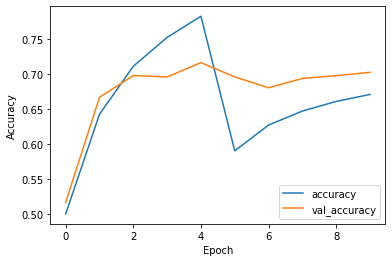

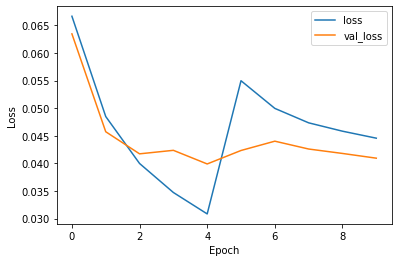

313/313 - 4s - loss: 0.0409 - accuracy: 0.7023
Test accuracy: 0.7023000121116638
Test loss: 0.04094371199607849


2021-12-07 20:58:10.233195: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


1563/1563 - 15s - loss: 0.0370 - accuracy: 0.7324
train accuracy: 0.732420027256012
Train loss: 0.036987509578466415


In [13]:
# Evaluation
plot_accuracy(history,history2)
plt.show()
plot_loss(history,history2)
plt.show()
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(f"Test accuracy: {test_acc}\nTest loss: {test_loss}")
train_loss, train_acc = model.evaluate(x_train,  y_train, verbose=2)
print(f"train accuracy: {train_acc}\nTrain loss: {train_loss}")

if history2:
    parametres['results'] = {
        'acc' : train_acc,
        'val_acc': test_acc,
        'loss': train_loss,
        'val_loss': test_loss,
        'acc_hist': history.history['accuracy']+history2.history['accuracy'],
        'val_acc_hist': history.history['val_accuracy']+history2.history['val_accuracy'],
        'loss_hist': history.history['loss']+history2.history['loss'],
        'val_loss_hist': history.history['val_loss']+history2.history['val_loss']
    }
else:
    parametres['results'] = {
        'acc' : train_acc,
        'val_acc': test_acc,
        'loss': train_loss,
        'val_loss': test_loss,
        'acc_hist': history.history['accuracy'],
        'val_acc_hist': history.history['val_accuracy'],
        'loss_hist': history.history['loss'],
        'val_loss_hist': history.history['val_loss']
    }data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYgAAAEGCAYAAAB/+QKOAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/MnkTPAAAACXBIWXMAAAsTAAALEwEAmpwYAABAyUlEQVR4nO3deXxU1fn48c/JnrBkI2ELEAJhD2GJEEAFQRAFwdYiWEvdt9b9W61at6pt/dl+rdpqv6LFpS7YYpWAiCKLC3sQSCBhCWELSUjIRvZtnt8fdwhJDBAgk0lmnvfrNa/M3Ll35slA7jPnPPecY0QEpZRSqjEPZweglFKqbdIEoZRSqkmaIJRSSjVJE4RSSqkmaYJQSinVJC9nB9BSunTpIpGRkc4OQyml2pWtW7ceF5Gwpp5zmQQRGRlJYmKis8NQSql2xRhz6HTPaReTUkqpJmmCUEop1SRNEEoppZqkCUIppVSTNEEopZRqkiYIpZRSTdIEoZRSqkmaIJQ6DRHhy13Z7MoscnYoSjmFywyUU6olpeeW8MRnO1m/P4+RvYP49FcTnB2SUq1OE4RS9VTW1PLGN+n8fU0avl4eXBQZzA+HCymtrKGDr/65KPeiXUxK2W1Kz+OqV77jpZV7uWJoN1b9z0TumxJNrU1IPFTg7PCUanX6lUi5vcKyKv60fDcfJx4hItift2++iMsGhgPQ0dcLb0/Dhv15TBzQ5HxmSrksTRDKbYkIS7Zn8tyyFArLq7lzYhQPTBmAv49n3T4BPl7ERgSxMT3PiZEq5RyaIJRbOni8lCc+28n3accZ0SuI938aw+DunZvcNz4qlH98s5+Syho6ah1CuRGtQSi3UlVj4++r9zHt5W/ZcaSQ564Zxid3jz9tcgAY1y+UWpuw5WB+K0aqlPPp1yHlNrYczOfx/yazL6eEGTHdeerqIXTt7HfW40b1Dsbb07AxPa+uNqGUO9AEoVxeUVk1L6zYzUebD9MzyJ+FN8UxeVDXZh/v7+PJiF5BbEzXFoRyL5oglMsSERJ2WEXogrJq7rg0igcujybA59z/24+LCuW1tfsprqimk5+3A6JVqu3RGoRySYfzyrjx7S3cv2g7PYP8SbhnAo9fNfi8kgNYhepam5B4UMdDKPehLQjlUqprbbz5XTqvfL0Pb08Pfj9rKL+I74Onh7mg1x3VJxgfTw+rDjFI6xDKPWiCUC5j66ECHv9vMnuOFTN9aDeenjWE7oH+LfLaft6ejOgdxAYdD6HciCYI1e4VlVfz4ordfLj5MN07+/HmL+OYOqT5Rejmio8K5e+r93GioprOWodQbkBrEKrdEhGWJWVy+Uvf8NHmw9wyoS8rH5rokOQAEB8Vgk0gUcdDKDehLQjVLh3JL+PJJTtZuyeXmJ6BvH3TRQzrGejQ9xzV26pDbNifd06XySrVXmmCUO1Kda2Nf35/gJe/3ounMTw1cwi/HNcHL0/HN4b9vD0Z2VvHQyj3oQlCtRvbDhfw2H+T2Z1dzNQhXfn9rKH0CGqZInRzxUeF8rfV+ygqrybQX+sQyrVpDUK1eScqqnlqyU5++o/1FJZV88b80bz5y7hWTw5gJQibwJYD2opQrk9bEKrNEhG+2JnNMwm7yC2p5MZxkfzmioFOnVF1ZO8gfLys8RCXO6gYrlRb4dC/NGPMdOAVwBN4S0ReaPT8X4HL7A8DgHARCbI/Vwsk2587LCKzHBmralsyC8t54rOdrN6dw9AenXnzl3HE9gpydlj4eXsyqncQGw/oeAjl+hyWIIwxnsBrwFQgA9hijEkQkZST+4jIg/X2vxcYWe8lykVkhKPiU23XtsMF3P5eIqWVtTwxYzA3jY9slSJ0c8VHhfLKKq1DKNfnyL+6MUCaiKSLSBWwCJh9hv2vBz5yYDyqHfg8KYt5CzYS4OPF0nsv5rZLotpUcgBr4j4R2Kx1COXiHPmX1xM4Uu9xhn3bjxhj+gB9gdX1NvsZYxKNMRuNMdec5rg77Psk5ubmtlDYyhlEhNfWpPHrD38gpmcgn/16Av3DOzo7rCbF9grC116HUMqVtZUi9TxgsYjU1tvWR0SOGmOigNXGmGQR2V//IBFZACwAiIuLk9YLV7Wkqhobj3+azOKtGcwe0YP/d+1w/Lw9z36gk1h1iGBNEMrlObIFcRToVe9xhH1bU+bRqHtJRI7af6YDa2lYn1AuorCsivn/3MTirRk8cHk0L88d0aaTw0nj+oWSknWCwrIqZ4eilMM4MkFsAaKNMX2NMT5YSSCh8U7GmEFAMLCh3rZgY4yv/X4XYAKQ0vhY1b4dPF7KT19fz7bDhbw8dwQPXD4AYy5sWu7WEq91COUGHJYgRKQGuAf4EkgF/i0iu4wxzxpj6l+yOg9YJCL1u4gGA4nGmB3AGuCF+lc/qfZv84F8rnl9HQVlVXxw+1iuGdlkearNiu0VaK9DaIJQrsuhNQgRWQ4sb7TtqUaPn2niuPVAjCNjU87z6bYMfrs4mYgQf96+6SL6hHZwdkjnzNfLk7jIYF0fQrm0tnX9oHJpIsJLX+3hwY93MLpPMJ/ePaFdJoeT4vuGsjtb6xDKdWmCUK2iorqW+xdt59XVacwZHcG7t4whMKB9DzKL72fVITZpHUK5KE0QyuHySiq54a1NJOzI5JHpA3nxZ8Px8Wr///WGRwTi522tD6GUK2or4yCUi0rLKebmd7aQc6KS128YxVUx3Z0dUovx9fIkrk+IjodQLqv9f41Tbda6tOP85PX1lFfZ+PjOcS6VHE6Kjwphd3YxBaVah1CuRxOEcohFmw9z48LNdA/047Nfj2dEG5iJ1RHio0IB2KSzuyoXpAlCtSibTfjTF6k8+t9kxvfvwuK7xxMRHODssBxmeEQQ/t6eOh5CuSStQagWU15Vy4Mfb2fFrmx+Ed+bZ64e2uZmYm1pPl4exEXqvEzKNbn2X69qNTknKpi7YANfpmTz5MwhPDd7mMsnh5Pio0LZnV1MXkmls0NRqkW5x1+wcqjUrBNc89o60nJKWDA/jlsv7ttu5lRqCSfrEDovk3I1miDUBVmzO4ef/WM9tSL8+85xTHXDdZqHRwTa6xDazaRci9Yg1Hl7b8NBnknYxeDunfnnjRfRLdDP2SE5hbenh87LpFyStiDUOau1Cc8k7OKpJbuYPCicf985zm2Tw0nj+oWy91gJx7UOoVyIJgh1Tkoqa7j9vUTeWX+QWy/uyxvz4+jgqw1RrUMoV6QJQjVbZmE5c/5vA9/szeW5a4bx5MwheHq4TzH6TGJ6BhLgo3UI5Vr0q59qluSMIm59dwtlVbX888Y4Jg0Md3ZIbYq3pwcXRYboxH3KpWgLQp3Vl7uyue6NDXh7evDJ3ePdKznU1oCttlm7xkeFsi9H6xDKdWiCUKclIrz5bTp3vb+VAd068emvxzOwWydnh9U68vbDisfhxSh4aTCs+SOcyDrjIfFRIQBs0mk3lIvQLibVpOpaG08t2cVHmw9zVUw3/nfOCPx9PJ0dlmPZbLB/FWxeAPtWgocnDJ4FVaXwzYvw3f/CoJkw5g7oMx4aDQYc1jOQDj6ebEg/zozhrjdzrXI/miDUjxSVV/PrD37g+7Tj3D2pHw9PG4iHKxejywtg+4ew+U0oOAAdu8KkR2H0TdCpm7VP/gFI/Cf88C9I+QzCh8CY2yHmOvDtCNjrEH1DdOI+5TKMiDg7hhYRFxcniYmJzg6j3cssLOfGhZs5cLyUP/4khusu6uXskBwneydseROS/g3VZdArHsbeAYOuBi+fpo+pKoOdn1itjOwk8O0MI26Ai26DLv35v2/288IXu9nyu8sJ6+Tbur+PUufBGLNVROKaek5bEKpOTa2N+z7aRlZRBe/dMobx/bs4O6SWV1sNu5dZrYVD68DLD2LmWK2B7rFnP94nAEbNh5G/gIwtVqLY8hZs+gf0m8y0vj/nRfzYmJ7H1bE9HP/7KOVAmiBUnX+s3U/ioQJemTfC9ZJDSQ5sfRcSF0JxJgT1ganPWSf6gJBzfz1joNcY63bFH+teO2r/bXznG0byxp9B9CPn99pKtRHaxaQA2H6kkGv/sZ4ZMd159fqRzg6nZYhARqL1LX/Xp2Crhn5TrCJz9FSrCN2Saqthz3JSl/wvgyt3gKcvxPzM6n7qOapl30upFqJdTOqMSitrePDj7XTt5Mtz1wxzdjgXrrocdv7XSgxZ2606wUW31dUJHMbTG4bM5tvcYdy/YiWfjUklYNd/YPsH0DPO6sYa+hPw0tqEah80QSie/zyVg3mlfHhbPIH+3s4O5/wVHoYt/4Qf3oPyfAgbDDP+F4bPBd/WG78xrl8of5JefB01i1lXPgs7Flk1j0/vhC9/B6N+CXG3QJALXwCgXIJDE4QxZjrwCuAJvCUiLzR6/q/AZfaHAUC4iATZn7sReML+3PMi8q4jY3VXK1OO8dHmw9w5MYpx/UKdHc65E4ED31gn4D3LrW2DZljdSJGX/GisQmsY0r0znXy92Jiex6zYHjD2Tiue9LVWnOtetm4Dr7JaFX0nOiVO1U7ZbFB2HIqzrVtJNngHWN2ZLcxhCcIY4wm8BkwFMoAtxpgEEUk5uY+IPFhv/3uBkfb7IcDTQBwgwFb7sQWOitcd5RRX8NtPkhjSvTP/M3Wgs8M5N5XF9m/mC+D4XggIhYsfhNE3O/2budfJ8RD152UyBvpdZt0KD1vF8q3vWldUdRlodX/FzgO/zs4LXDmXrRZKc+0n/WNQnAXF9p/1H5fmgK2m4bHdY9tXggDGAGkikg5gjFkEzAZSTrP/9VhJAeAKYKWI5NuPXQlMBz5yYLxuRUR4ZHESpZU1vDJvBD5e7WTWldy91tiF7R9BVTH0HA0/eQOGXAPebWdNinFRoazencOxExV07dworqDecPkzMPFRq3i+eQF88TCs+r2VJC66HcIHOSVu5QC1NfYTf6MTfUn2qVZAcbZ14hfbj48PCIVO3a0BnOFDoVPXU487dbNuHR2zkqMjE0RP4Ei9xxnA2KZ2NMb0AfoCq89wbM8mjrsDuAOgd+/eFx6xG/nXxkOs3ZPL72cNJbprvf752mrISQFPH/D2B+8O9p8B4OGkJGKrhb0rrBNp+lortmHXWifSiNHOieksTq4PsTE9j9kjfvRf1+LtByOut24ZW63E98O/rHEVkZdY3VIDrwJPLRW2STVV1om/8Ym+JLvhN//S3CZO/AY6dLGf3LtBt5hTJ/pO3U+d+DuEn37QZitoK//z5gGLRaR502baicgCYAFYl7k6IjBXlJZTzB8+T2XigDB+Oa7PqScytkLCvZCzq+kDvfytZOFTL2nUv+8dYA0ka3Df/nyD7ac5pvFlp6V5sO092LIQig5D554w+UkYdSN0DHPcB9QChvToTCc/rzMniPoiRlu3ac9bRfbEhfDv+dbvHHczjLqpzf/O7ZqI1W1ZlmfdSo/b7x+338+vd9++T+WJH7+O8YAOYadO9D1G1Pu239369t+xG3QMt656a+McmSCOAvU7gyPs25oyD/h1o2MnNTp2bQvG5raqamzcv2g7HXy9+POc4RhjrMnoVv/BGg3csRvM+rs1v1BVmTUFRXXZ6e9Xl1t/PNUZ9Z4rt+5zjjnb07dhIik8DLWV1rfpK/7Qrr5Ne3oYxp7PvEwdusAlD8GE+0+1mlY/D2v/H0RPgyGzYMAV4B/smMBdha321Em97oRvP9HX3c+zvoScvF9b1fRrefpa/y4BIRDQBUL6Wt0+AV1OtQJOtgQ6hLWb/6PN4cjfZAsQbYzpi3XCnwf8vPFOxphBQDCwod7mL4E/GmNO/hVMAx5zYKxu46WVe9mVeYIF80cT3skP9q+GpQ9A4SGIu9XqG2+JQqmIPVGUQ3Wp9bOq9FRSqSo99VxdUjm5X5l1v/8Ua8K88MEXHo8TxEeF8nVqDtlFFee+ZreHp3U11qAZVt1l69uw6zPY8zl4eFlXPg2ZBQNnuF/LouAgHNli9dnX/0ZfPxGUF3LaLyi+gdAh1DrJB0ZAj9iGJ/y6+/Z9fDq67VVmDksQIlJjjLkH62TvCSwUkV3GmGeBRBFJsO86D1gk9YZ0i0i+MeY5rCQD8OzJgrU6fxvT83jj2/1cP6YX0/r6wKd3w44PIbQ/3PyFNYV1SzHGag34BADt8PLZFlC/DnHNyGZ0M51O2ACY/ieY9gfI/AFSlkBqAiy9H5Y9CL3HW8li0EwIvID3aasqS+Dg99ZU7GmrIH//qeeMp/2EHmqd3LsOPXU/wP6tv+6+fT8n9um3NzrVhpsoKq/mqle+w9sDVkzLx2/lo9Y01xMegEsfblNXALmKWpsw8tmvuCqmOy9cO7xlX1wEju2ElAQrWeTutrb3jLOSxeBZVldIeyQC2cmnEsLhjdY0KV7+EHmx1bKMvAQ69wC/IOddPOEidKoNxVNLdiInMlnS/zP8PlsJPUbC/E+tqyeUQ3h6GMb0DWVjugPWqTbG+rfrFgOTf2d1Q6UmQOpSWPmUdesacypZhA1s290kpcet7s60VdbP0hxre/hQiL/LmkOr9zj9ItPKNEG4gSXbjtAh+V+s8V+Eb6bNulJm7N0uVUxrq+KjQvg69RhZReV0D/R33BuFDYCw38Clv4GCQ1aiSE2ANX+wbqHRp5JF91jnJ4vaajiyyZ4QVkHWDmu7f4h9QOEU6DcZOuvKfM6kZwgXl52eTM8lt/NH71RsvS6FWa9ASJSzw3Ib9esQPxkZ0TpvGtwHxt9j3U5kWaO1UxPg+5etZVODeluJYvAsiLio9bpo8tNPtRAOfAtVJVYNodcYuOwJ6D8Zuo9o+Vl21XnTBOGqaquxrXuVkNV/wl98yLv8JUIvvsX53xzdzJDunQn092bj/vzWSxD1de5uzfc05nbrks49y61ksekN2PB369LMwTOtZNFnQsu2KiuL4cB3p2oJBQes7UG9rUWa+k+BvpeCX2DLvadqUZogXFHmNlhyLx7HkllZO4baK15k1sUussZDO+PhYRjTN4SNBxxQhzhXHUKt1fBGzYeKItj7FaQugW0fWKO3/UNg0FUweDZETTz3acltNmsZ1v2rIG211YVkq7bGtEReAvF3W11Hof30i0o7oQnClVSVwdo/wYa/U+3fhftqHsIMnslrE0Y4OzK3Fh8VysqUY2QWltMjyIF1iHPhFwjD51i3qjJI+9qqW6QkwLb3rTU0BlxhtSz6X26/XLkJJTmnisvpa6xpJcAqkI/7lb24HK9rYLRTmiBcRfo31nXxBQeoGfFLrk27gmMBfqy4JsYaLa2cZly9OsRPRzmhm+lsfAKsAvaQWVBTaf1fSl0Cu5dD8n+sy0ujL7daFv0mW1OxnCwuZydbrxHQpWFxuZNjJo9TrUsTRHtXXgBfPQnb/mUVn29cxrNJwSQdP8T7t44guIMOCnK2Qd06WXWItpog6vPyhQHTrNvMGji0zn757DKrhXGShxf0iocpT1lJodtwHY/ggjRBtGcpS2D5w9Y15BMegEmPsmZ/Me9t2MKtF/fl4uguzo5QYdUhxvYNYYMjxkM4kqeXVYuImghX/hkytsDBbyF8iFVT0LUrXJ4miPboRBYs/411+WK34fDzf0OPEeSVVPLw4iQGdevEw1e0swWAXNy4fqF8lXKMjIIyIoJP05/flnl4QO+x1k25DU0Q7YmINRX0V09as5xe/gyMuxc8vRARfvtJMifKq3n/tjH4eeu15G3JyfEQm9LziRjdDhOEckvaadhe5O2Hd6+GpfdB9+Fw93priU37deuLthzh69RjPDJ9IIO6adO/rRnYtRPBAd7tr5tJuTVtQbR1tTXWgKa1f7Lmpb/6FRj5ywYFwQPHS3l2aQoX9+/CLRPa6QRtLs6qQzhoXialHEQTRFuWlQQJ91jz1AyaCVf95Udz01TX2nhg0TZ8vDz4y5xYPDz0kta2Kj4qhBW7sjmSX0avEO1mUheuorqWXZknqKyuZXz/lr8oRRNEW1RdDt/8P1j3qjV//XXvWQOWmhjP8LdV+9iRUcTrN4w690VpVKuK73dqPIQmCHWuqmtt7MkuJimjiOSjhew4UsTeY8XU2IQh3Tuz/P5LWvw9z5ogjDFXA5+L/GjVbeUIB7+HhPusRVFG/sKaefU0y0smHszn72vS+NnoCK6K0Vkv27oB4VYdYmN6PnPiep39AOW2bDYh/XgpSRmFJGUUsSOjkJTME1TWWKfhQH9vhkcEcuegKIZHBBEbEeSQOJrTgpgLvGyM+QRrVbjdDonE3dVWW2Matr4NwZHwyyUQNem0uxdXVPPgv7fTM9ifp68e0mphqvPn4WGIj9I6hGpIRMgoKCcpo6guIew8WkRxZQ0AAT6eDOsRyPz4PgzvFURsRCC9QwJaZYaEsyYIEfmFMaYzcD3wjjFGgLeBj0Sk2NEBuo2dn1jJIf5XMPnJ0899Y/f7pSkcLSjnP3eNo5OfdysFqS5UfFQoX+zUOoQ7yy2uJCmjkB32hJCcUUReaRUAPp4eDO7eidkje9S1DPqHd8TTSbXFZtUgROSEMWYx4A88APwEeNgY86qI/M2B8bmPlATo3BOu+ONZZ7pcnpzF4q0Z3De5P6P7hLRSgKolnBwPsUHrEG6hqLyaZHsXUbI9IWQWVQDgYSA6vBOTB4XXtQwGduuEr1fbGcPUnBrELOBmoD/wHjBGRHKMMQFACqAJ4kJVllgTn42+6azJIbuogsf+m0xsryDunRLdOvGpFjOga0dCOviwMT2P67QO4VLKq2rZlVlU1zJIyijiwPHSuucjQwOIiwxheEQgwyOCGNqjMx182/Z1Qs2J7lrgryLybf2NIlJmjLnVMWG5mbSVUFMBg68+4242m/A//9lOVY2Nl+eOwNtTxzm2N8YY4qNC2Lg/DxHRmXbbKRFhf24pG9Pz6loI+3JKqLUJAN06+zE8IpCfjY6wEkLPIAID2l9XcHMSxDNA1skHxhh/oKuIHBSRVY4KzK2kLrWmS+497oy7LVx3gHVpefzppzH07dKhlYJTLS0+KpTlydkcyS+nd6h2M7UXZVU1rE/LY+3eHNbuySWjoByA4ABvhkcEMW1IV4ZHBDE8IpDwzq5xyXlzEsR/gPH1Htfat13kkIjcTXUF7P0Shl17xrV4d2ef4MUVe5g6pCvzLtKuifas/voQmiDaLhEhLaeEtXtyWbs3hy0HCqiqtRHg48n4fl24a2I/Lonu0mpXFDlDcxKEl4hUnXwgIlXGGF1koKWkr7UWbx8y67S7VFTXcv9H2+ns780LP9UFgNq7/uEdCT1Zh9Bk36aUVNawPu04a/fm8s2eXI4WWq2EAV07ctOESCYOCCMuMrhNFZIdqTkJItcYM0tEEgCMMbOB444Ny42kLgXfQIi89LS7/PnLPew5VszbN19EaEddurG9s+oQoWxI1zqEs4kIe4+VsHZPDt/szWXLwXyqa4UOPp5M6N+FX1/Wn4kDw+jZVpaKbWXNSRB3AR8YY/4OGOAI8EuHRuUuaqthz+cwcDp4Nd0o+37fcf75/QFuHNeHywaGt3KAylHi+4XyeXIWh/PL6BOq9aTWVFxRzbq0PL7Zm8M3e3LrLjsd2LUTt0zoy8SBYcT1CcHHSy8Cac5Auf1AvDGmo/1xSXNf3BgzHXgF8ATeEpEXmtjnOqxCuAA7ROTn9u21gH3BWw6LyOn7YNqrQ+usJUMHN/2rFZRW8T//2U7/8I48dtXgVg5OOdK4KGv8ysb0PE0QDiYi7DlWbNUS9uSQeLCAGpvQ0deLCf1DuXdKNBMHhNHDTVsJZ9Ksi3CNMTOAoYDfyeawiDx7lmM8gdeAqUAGsMUYkyAiKfX2iQYeAyaISIExpv5X5HIRGXEOv0v7k7oUvAOsRd4bEREe/zSZ/NIq/nnjRboAkIvpF9aRLh192bA/j7kX9XZ2OC7nREU16/YdZ+2eXL7Zm0v2CauVMKhbJ267JIpJA8MY1TtYWwln0ZyBcv8HBACXAW8BPwM2N+O1xwBpIpJuf51FwGyswXUn3Q68JiIFACKSc07Rt2c2m7UQfP/Lm5xWY/HWDL7Ymc2jVw5iWM9AJwSoHKluPER6vtYhWoCIkJpVXHcJ6g+HrFZCJ18vLo7uwqSBYUwcEK4zHp+j5rQgxovIcGNMkoj83hjzv8AXzTiuJ1a94qQMoPGCtgMAjDHrsLqhnhGRFfbn/IwxiUAN8IKIfNb4DYwxdwB3APTu3c6+hWVsgZJsGDL7R08dzivjmYRdjO0bwu2XRDkhONUa4qNCWZaUxaG8MiJ1XMs5KyqvZl3a8boC87ETlQAM7t6Z2y+NYtKAMEb1CdYBpRegOQmiwv6zzBjTA8gDWmpuaS8gGpgERADfGmNiRKQQ6CMiR40xUcBqY0yyvR5SR0QWAAsA4uLipIViah2pCeDpA9HTGmyuqbXx4L+34+FheGnuCKdN0qUcr/68TJogmqe8qpaEHUf5ZOtRth4uoNYmdPLz4tLoMCYODGPigDC6usggtbagOQliqTEmCPgz8ANWMfnNZhx3FKh/kXeEfVt9GcAmEakGDhhj9mIljC0ichRARNKNMWuBkcB+XIGIlSCiLgO/hutHv752P1sPFfDKvBFue2mdu+gX1oGwTr5sTM/j+jHtrAXcyvbnlvD+xkMs3ppBcUUN0eEduWtiFJMGhjOyVxBe2kpwiDMmCGOMB7DK/o3+E2PMMsBPRIqa8dpbgGhjTF+sxDAP+HmjfT7Dmkb8bWNMF6wup3RjTDBQJiKV9u0TgBeb/2u1cVk7oPAwXPpIg83bjxTyyqp9zB7Rg9kjejopONVaTo6H2KjjIZpUU2vj69Rj/GvjIdal5eHtabhyWHfmj+tDXJ9g/bxawRkThIjYjDGvYX17R0QqgcrmvLCI1Bhj7gG+xKovLBSRXcaYZ4FE+8C7L4FpxpgUrCk8HhaRPGPMeOANY4wN8MCqQaSc5q3an9SlYDxh4FV1m8qqanhg0Ta6dfbj2dnDnBicak3xUSEs3ZHJgeOlRIV1dHY4bcKxExUs2nyEjzYfJvtEBT2D/Hn4ioFcF9eLsE46ULQ1NaeLaZUx5lrgvyJyTv38IrIcWN5o21P17gvwkP1Wf5/1QMy5vFe7kroUIidAh9C6TQnbMzmYV8b7t44l0L/9zfqozk983bxM+W6dIESEDel5vL/xEF/tOkaNTZg4IIznrxnGZYPCtRbnJM1JEHdincBrjDEVWKOpRUQ6n/kw1aTcPXB8D4y5vcHmZUlZRIYGMKF/6GkOVK4oqksHwu11iJ+Pdb86xImKav67NYP3Nx0mLaeEoABvbrm4Lz8f01sL921Ac0ZSd2qNQNxGaoL1c9DMuk15JZWs33+cX03qr/2qbsZd52XalVnE+xsP89m2o5RX1xLbK4i/zIll5vDuOii0DWnOQLkmZ5FrvICQaqaUBIgYA51PXSn8xc5sbAIzY1vq6mHVnsRHhZKwI5P046X0c+FuporqWr7YmcW/Nhzih8OF+Hl7MDu2J7+I70NMhA4GbYua08X0cL37flgjpLcCP54fQp1ZwUHIToKpzzXYvCwpk35hHRjYVRtr7mhcv1PrQ7higjiSX8YHmw7z78Qj5JdW0bdLB56cOYSfjYpol6usuZPmdDE1WAfTGNMLeNlRAbm01GXWz3pLi+acqGDTgXzumxztNt0LqqHI0AC6drbmZbphbB9nh9Miam3CN3tzeH/jYdbsycEAU4d0ZX58JOP7heKhRed24XxWzM4AdGrR85GaAN1iIKRv3ablyVmIwNXaveS2TtYh1qW1/zpEXkkl/07M4INNh8goKCesky/3To7m+jG96B6oAz/bm+bUIP6GNXoarDEJI7BGVKtzUZwNRzbBZU802LwsKYtB3TrRP1y7l9zZuKhQlmzPZH9uKf3D21c3k4jww+FC3t94iM+TsqiqtREfFcJjVw5m2tCuOhdSO9acFkRivfs1wEciss5B8biu1KXWz3rdS5mF5SQeKuA30wY4KSjVVtSfl6m9JIiyqhqWbM/kXxsOkZJ1gk6+Xvx8bG9uGNubaK2nuYTmJIjFQIWI1IK1zoMxJkBEyhwbmotJXQqh0RA2sG7T8uQsAGYO7+GsqFQb0Sc0gG6d/diYnsf8+LZdh0jLKeb9jYf5ZGsGxZU1DOrWiT/+JIbZI3rQwfd8eq1VW9WskdTA5cDJleT8ga+A8Y4KyuWU5cPB7+HiB6Be//KypCyG9eysA4IUxhjG9Qvlu325bbYOceB4KU98lsy6tDx8PD24KqYb88f1YVRvnRfJVTUnQfjVX2ZUREqMMT9e4Uad3p7lILUNupeO5Jex/Ughj145yImBqbYkPiqET7cdZX9uSZurSX2RnMXDi5Pw8jQ8Mt2aF6lLR50XydU1J0GUGmNGicgPAMaY0UC5Y8NyMalLIbA3dB9Rt+lze/fSjBi9eklZ6uoQ+/PaTIKoqrHxwhe7WbjuACN6BfHaDaN0Gno30pwE8QDwH2NMJtY8TN2AuY4MyqVUnID9q+Gi2xt1L2US2yuIXiHaGFOW3iEBdA/0Y2N6PvPHRTo7HDILy7nnwx/44XAhN42P5PGrBusazm6mOQPlthhjBgEnq6t77Av8qObY9xXUVjXoXjp4vJSdR0/wxAwdTqJOMcYwLiqUb/Y6vw7xzd5cHli0jepa4bWfj2LGcG3puqOzfh0wxvwa6CAiO0VkJ9DRGPMrx4fmIlKXQseu0OvUctzLkjIBuEq7l1Qj8VGh5JVWsS+n5Ow7O0CtTXhp5V5uenszXTv7kXDPBE0Obqw57cXb7SvKASAiBcDtp99d1akuh30rYdAM8Dj1US9LyiKuTzA9tC9XNXJqfYi8Vn/v4yWV3LhwM6+u2se1oyL49FcT3HqNCtW8BOFp6rV1jTGegI/jQnIh+1dDdSkMnlW3KS2nmN3ZxczUb2WqCb1C/OkZ5N/qCWLLwXxmvPodWw7m8+K1w/nLnFj8fXTabXfXnCL1CuBjY8wb9sd3Al84LiQXkpIAfkEQeXHdpmVJWRij3UuqacYYxkaFsHZPLjabOHxSOxHhre8O8MKK3fQK9uftX41hSA9dC0xZmtOC+C2wGrjLfkvGGiynzqSmCvZ+Ya077WlNaSwiLEvKYkxkCOGd/ZwcoGqr4qNCyW+FOkRReTV3/msrf1ieyrQhXUm492JNDqqBsyYIEbEBm4CDWGtBTAZSHRuWCzj4HVQUwZBT3Ut7jhWTllPCzFidWkOd3rhWqEPsPFrE1X/7ntW7c3hy5hBev2EUnf10bQbV0Gm7mIwxA4Dr7bfjwMcAInJZ64TWzqUmgHcHiDr1cS3bkYWHgSuHdXNiYKqt6xUSQM8gfzbsz+PG8ZEt+toiwkebj/DM0l2EdvDh4zvHMbpPcIu+h3IdZ6pB7Aa+A2aKSBqAMebBVomqvbPVwu7PYcA08La6kqzupUzG9+uiUxSos4qPCmX17mMtWocoq6rhiU938t9tR7kkuguvzBtJSAe93kSd3pm6mH4KZAFrjDFvGmOmYI2kVmdzeCOU5ja4emlX5gkO5pXp1UuqWcb1C6WgrJq9OcUt8nppOSVc89o6Pt1+lAcvH8A7N4/R5KDO6rQJQkQ+E5F5wCBgDdaUG+HGmH8YY6a1UnztU+pS8PSF6Kl1m5YmZeLlYZiu3UuqGcb2DQGseZkuVMKOTGb9/XvySqp475Yx3H95NJ665KdqhuYUqUtF5EP72tQRwDasK5tUU0SsBNF/Cvh2sm8SPk/K4uLoLgQF6Lc2dXa9QgKICL6w8RCVNbU8tWQn9320jSHdO/P5fZdwSXRYC0apXN05zbwlIgUiskBEpjgqoHYv8wc4kdFg7qUdGUVkFJTrwkDqnIyLCmXTgXxsNjn7zo0cyS/juv/bwHsbDnH7JX356I54ugXqpdXq3Dh0akZjzHRjzB5jTJox5tHT7HOdMSbFGLPLGPNhve03GmP22W83OjLOFpW6FDy8YMD0uk3LdmTi4+nB1CFdnRiYam/io0IpLKtmd/a51SFWpR5j5t++J/14KW/MH83vZgzRdaHVeXHY+oD2KTleA6YCGcAWY0yCiKTU2ycaeAyYICIFxphw+/YQ4GkgDhBgq/3YAkfF2yJErNHTkZdAgNWHbLMJnydncemALgT663XmqvnGRln/hzam5zVrAFtNrY2XVu7l9bX7GdqjM6/fMIo+obpaoTp/jvxaMQZIE5F0EakCFgGzG+1zO/DayRO/iOTYt18BrBSRfPtzK4HptHU5qZC/v0H30g+HC8gqqtDuJXXOIoID6BXSvDpEzokKbnhrE6+v3c/1Y3rzyd3jNTmoC+bIFcZ7AkfqPc4AxjbaZwCAMWYd4Ak8IyIrTnNsz8ZvYIy5A7gDoHfv3i0W+HlLXQoYGDSzbtOypCx8vTy4XLuX1HkYFxXKl7vOPB5iw/487v1oG6WVNbx0XSw/HRXRylEqV+XsjkkvIBqYhDVi+01jTFBzD7YXzONEJC4srA1cnZGaAL3joZOVDGrt3UuXDQyno68jc7FyVfFRoRSVV5OafeJHz9lswmtr0rjhrY109vdiyT0TNDmoFuXIBHEU6FXvcYR9W30ZQIKIVIvIAWAvVsJozrFtS95+OLazQffS5gP55BZXMjNWB8ep83NqfYj8BtsLy6q47b1E/vzlHmYM70HCPRczoGvbWMdauQ5HJogtQLQxpq8xxgeYByQ02uczrNYDxpguWF1O6cCXwDRjTLAxJhiYZt/WdqUutX7WSxCfJ2fi7+3J5EHhTgpKtXc9gvzpExrQYMDcjiOFzHj1e77bl8uzs4fy6rwR2kJVDuGw/1UiUmOMuQfrxO4JLBSRXcaYZ4FEEUngVCJIAWqBh0UkD8AY8xxWkgF4VkTyf/wubUjqUug+AoKsWkhNrY0vkrOZMjicAB/941XnL75vKF/szKLWJnyw6RDPLUshvJMfi+8aT2yvIGeHp1yYQ89cIrIcWN5o21P17gvwkP3W+NiFwEJHxtdiio7C0USYUversTE9n7zSKp17SV2w+H4hfJx4hBve2sjG9HwmDwrnpetidVS+cjj9atsSdi+zftabnG9ZUiYdfDyZNFC7l9SFOVmH2Hwgn0emD+SuS/s5fKU5pUATRMtIXQphg6BLNADVtTZW7Mpm6pCu+Hnrur7qwnQP9OcPPxnGgK6duCgyxNnhKDeiCeJClR6HQ+vgkt/Ubfo+7TiFZdU6OE61mBvG9nF2CMoNOXscRPu3+3MQW4Orl5btyKKTnxeXDOjixMCUUurCaIK4UKlLITgSusUA1hTLX6Vkc8XQbvh6afeSUqr90gRxIcoLIX2t1XowVtHwu73HKa6o0auXlFLtniaIC7HvK7BV/+jqpaAAbyb01+4lpVT7pgniQqQsgU7doWccABXVtaxMOcb0od10/n2lVLunZ7HzVVUKaausmVs9rI9x7Z4cSqtq9eolpZRL0ARxvtJWQU05DDnVvbQ0KYvQDj7ER+m16kqp9k8TxPlKTQD/EOg9HoCyqhpWp+ZwZUw3vLR7SSnlAvRMdj5qKmHvlzDoKvC0xhquSs2hvFq7l5RSrkMTxPlI/wYqT8DgUyuofp6URXgnX50KQSnlMjRBnI/UBPDpBFETASiprGHNnhyuiumOp06ippRyEZogzlVtDexZDgOuAC9fAL5OOUZljY2rdeU4pZQL0QRxrg6vh7K8BlcvLUvKpHugHyN7BTsxMKWUalmaIM5V6lLw8of+lwNQVF7NN3tzmRHTXefoV0q5FE0Q58JmsxJE/yng0wGAr3ZlU10rzIzVq5eUUq5FE8S5OLoVirMazb2URa8Qf2IjAp0YmFJKtTxNEOciNQE8vK0CNVBQWsW6tOPMiOmBMdq9pJRyLZogmkvEShBRE8E/CIAvd2VTYxOd2lsp5ZI0QTTXsZ1QcLDhynFJWfTt0oGhPTo7Ly6llHIQTRDNlZIAxgMGzgDgeEkl6/cfZ+bw7tq9pJRySZogmit1qTUxX8cwAL7YmY1NYIZ2LymlXJQmiOY4vg9yUxt2L+3IpH94RwZ27eTEwJRSynE0QTRHaoL1c/BMAI6dqGDzwXztXlJKuTSHJghjzHRjzB5jTJox5tEmnr/JGJNrjNluv91W77naetsTHBnnWaUuhZ6jITACgOXJWYigU3srpVyal6Ne2BjjCbwGTAUygC3GmAQRSWm068cick8TL1EuIiMcFV+zFR6GzG1w+e/rNi1LymJQt070D+/oxMCUUsqxHNmCGAOkiUi6iFQBi4DZZzmm7UldZv201x8yC8vZeqiAq3VqDaWUi3NkgugJHKn3OMO+rbFrjTFJxpjFxphe9bb7GWMSjTEbjTHXNPUGxpg77Psk5ubmtlzk9aUmQPhQCO0HWN1LADNi9OolpZRrc3aReikQKSLDgZXAu/We6yMiccDPgZeNMf0aHywiC0QkTkTiwsLCWj664mNweGODqb2XJmUxrGdnIrt0aPn3U0qpNsSRCeIoUL9FEGHfVkdE8kSk0v7wLWB0veeO2n+mA2uBkQ6MtWl7PgekrnvpSH4ZO44UanFaKeUWHJkgtgDRxpi+xhgfYB7Q4GokY0z9fppZQKp9e7Axxtd+vwswAWhc3Ha8lAQI6QfhQwCrOA3avaSUcg8Ou4pJRGqMMfcAXwKewEIR2WWMeRZIFJEE4D5jzCygBsgHbrIfPhh4wxhjw0piLzRx9ZNjleXDwe9g3D1gH+uwLCmTEb2C6BUS0KqhKKWUMzgsQQCIyHJgeaNtT9W7/xjwWBPHrQdiHBnbWe1dAbaaurUfDhwvZVfmCZ6YMdipYSmlVGtxaIJo11KXQuee0HMUYE2tATr3klLNVV1dTUZGBhUVFc4ORQF+fn5ERETg7e3d7GM0QTSlsgTSVkHczXXdS58nZ3FRZDDdA/2dHJxS7UNGRgadOnUiMjJSp6RxMhEhLy+PjIwM+vbt2+zjnH2Za9u07yuorazrXkrLKWZ3drFevaTUOaioqCA0NFSTQxtgjCE0NPScW3OaIJqSuhQCukDveACW7sjCGLhyWDcnB6ZU+6LJoe04n38LTRCNVVdYLYhBM8DDExFhWVImY/uGEN7Zz9nRKaVUq9EE0Vj6GqgqqRs9vTu7mP25pdq9pJRyO5ogGktdCr6BEHkpYI198PQw2r2klDqtmpoaZ4fgEHoVU3211bD7cxg4Hbx87N1LWYzvF0poR19nR6dUu/X7pbtIyTzRoq85pEdnnr566Fn3u+aaazhy5AgVFRXcf//93HHHHaxYsYLHH3+c2tpaunTpwqpVqygpKeHee+8lMTERYwxPP/001157LR07dqSkpASAxYsXs2zZMt555x1uuukm/Pz82LZtGxMmTGDevHncf//9VFRU4O/vz9tvv83AgQOpra3lt7/9LStWrMDDw4Pbb7+doUOH8uqrr/LZZ58BsHLlSl5//XU+/fTTFv2MLpQmiPoOfg8VhXVXL+3KPMGhvDJ+NelH8wQqpdqJhQsXEhISQnl5ORdddBGzZ8/m9ttv59tvv6Vv377k5+cD8NxzzxEYGEhycjIABQUFZ33tjIwM1q9fj6enJydOnOC7777Dy8uLr7/+mscff5xPPvmEBQsWcPDgQbZv346Xlxf5+fkEBwfzq1/9itzcXMLCwnj77be55ZZbHPo5nA9NEPWlJoB3APSbDMDSpEy8PAxXDNXuJaUuRHO+6TvKq6++WvfN/MiRIyxYsIBLL720bjxASEgIAF9//TWLFi2qOy44OPisrz1nzhw8PT0BKCoq4sYbb2Tfvn0YY6iurq573bvuugsvL68G7zd//nzef/99br75ZjZs2MB7773XQr9xy9EEcZKt1locKHoq+AQgInyelMUl0V0ICvBxdnRKqfOwdu1avv76azZs2EBAQACTJk1ixIgR7N69u9mvUf/y0MbjCDp0ODXt/5NPPslll13Gp59+ysGDB5k0adIZX/fmm2/m6quvxs/Pjzlz5tQlkLZEi9QnZWyB0py67qXtRwrJKChnhl69pFS7VVRURHBwMAEBAezevZuNGzdSUVHBt99+y4EDBwDqupimTp3Ka6+9VnfsyS6mrl27kpqais1mO2ONoKioiJ49rTXR3nnnnbrtU6dO5Y033qgrZJ98vx49etCjRw+ef/55br755pb7pVuQJoiTUhLA0weipwHW1N4+nh5MG9rVyYEppc7X9OnTqampYfDgwTz66KPEx8cTFhbGggUL+OlPf0psbCxz584F4IknnqCgoIBhw4YRGxvLmjVrAHjhhReYOXMm48ePp3v308/F9sgjj/DYY48xcuTIBlc13XbbbfTu3Zvhw4cTGxvLhx9+WPfcDTfcQK9evRg8uG1OAmpExNkxtIi4uDhJTEw8v4NF4OXhED4Ybvg3Npsw/oXVDOsZyFs3xrVsoEq5idTU1DZ74msr7rnnHkaOHMmtt97aKu/X1L+JMWarffXOH9EWBEDWdig6XLdy3NbDBWSfqODqWJ25VSnlGKNHjyYpKYlf/OIXzg7ltNpeVcQZUpeC8YSBVwHW1N6+Xh5MGazdS0opx9i6dauzQzgrbUGAlSAiJ0CHUGptwvKd2UweFE5HX82fSin3pQki/wAc31t39dLmA/nkFlfq3EtKKbenX5FD+sIDO8G3E2DNveTv7cnkQeFODkwppZxLEwRAUC8AamptrNiZzZTB4fj7eDo5KKWUci7tYqpnQ3oeeaVV2r2klFJogmhg2Y4sOvp6MWlgmLNDUUo5QceOHZ0dQpuiXUx2VTU2VuzKZuqQrvh5a/eSUi3qi0chO7llX7NbDFz5Qsu+ZhtRU1PTJuZm0haE3bq04xSVVzNzuA6OU8pVPProow3mV3rmmWd4/vnnmTJlCqNGjSImJoYlS5Y067VKSkpOe9x7771XN5XG/PnzATh27Bg/+clPiI2NJTY2lvXr13Pw4EGGDRtWd9xf/vIXnnnmGQAmTZrEAw88QFxcHK+88gpLly5l7NixjBw5kssvv5xjx47VxXHzzTcTExPD8OHD+eSTT1i4cCEPPPBA3eu++eabPPjgg+f7sZ0iIi5xGz16tFyIhz7eLjFPr5DK6toLeh2llCUlJcXZIcgPP/wgl156ad3jwYMHy+HDh6WoqEhERHJzc6Vfv35is9lERKRDhw6nfa3q6uomj9u5c6dER0dLbm6uiIjk5eWJiMh1110nf/3rX0VEpKamRgoLC+XAgQMydOjQutf885//LE8//bSIiEycOFHuvvvuuufy8/Pr4nrzzTfloYceEhGRRx55RO6///4G+xUXF0tUVJRUVVWJiMi4ceMkKSnpR79DU/8mQKKc5rzq/DZMG1BZU8tXKdlMH9oNHy9tVCnlKkaOHElOTg6ZmZnk5uYSHBxMt27dePDBB/n222/x8PDg6NGjHDt2jG7dzrzui4jw+OOP/+i41atXM2fOHLp06QKcWu9h9erVdWs8eHp6EhgYeNZFiE5OHAjWYkRz584lKyuLqqqquvUrTrduxeTJk1m2bBmDBw+murqamJiYc/y0fsyhZ0NjzHRjzB5jTJox5tEmnr/JGJNrjNluv91W77kbjTH77LcbHRnnt3uPU1xRw8xYvXpJKVczZ84cFi9ezMcff8zcuXP54IMPyM3NZevWrWzfvp2uXbv+aJ2HppzvcfV5eXlhs9nqHp9pfYl7772Xe+65h+TkZN54442zvtdtt93GO++8w9tvv91i04c7LEEYYzyB14ArgSHA9caYIU3s+rGIjLDf3rIfGwI8DYwFxgBPG2POvrzTeVqWlElwgDfj+4U66i2UUk4yd+5cFi1axOLFi5kzZw5FRUWEh4fj7e3NmjVrOHToULNe53THTZ48mf/85z/k5eUBp9Z7mDJlCv/4xz8AqK2tpaioiK5du5KTk0NeXh6VlZUsW7bsjO93cn2Jd999t2776datGDt2LEeOHOHDDz/k+uuvb+7Hc0aObEGMAdJEJF1EqoBFwOxmHnsFsFJE8kWkAFgJTHdEkBXVtXydcozpw7rh7andS0q5mqFDh1JcXEzPnj3p3r07N9xwA4mJicTExPDee+8xaNCgZr3O6Y4bOnQov/vd75g4cSKxsbE89NBDALzyyiusWbOGmJgYRo8eTUpKCt7e3jz11FOMGTOGqVOnnvG9n3nmGebMmcPo0aPruq/g9OtWAFx33XVMmDChWculNofD1oMwxvwMmC4it9kfzwfGisg99fa5CfgTkAvsBR4UkSPGmN8AfiLyvH2/J4FyEflLo/e4A7gDoHfv3qOb+02gvpwTFTz3eSo3jO1NfJS2IJRqKboeROubOXMmDz74IFOmTGny+fa2HsRSIFJEhmO1Et49y/4NiMgCEYkTkbiwsPMb3Bbe2Y+/XT9Sk4NSqt0qLCxkwIAB+Pv7nzY5nA9HXsV0FOhV73GEfVsdEcmr9/At4MV6x05qdOzaFo9QKaUaSU5OrhvLcJKvry+bNm1yUkRnFxQUxN69e1v8dR2ZILYA0caYvlgn/HnAz+vvYIzpLiJZ9oezgFT7/S+BP9YrTE8DHnNgrEopBxARjDHODuOcxMTEsH37dmeH0eLOp5zgsAQhIjXGmHuwTvaewEIR2WWMeRZrYEYCcJ8xZhZQA+QDN9mPzTfGPIeVZACeFZF8R8WqlGp5fn5+5OXlERoa2u6ShKsREfLy8vDz8zun4xxWpG5tcXFxkpiY6OwwlFJ21dXVZGRknPNYAeUYfn5+RERE4O3t3WD7mYrUOpJaKeUQ3t7edaN/Vfvk7KuYlFJKtVGaIJRSSjVJE4RSSqkmuUyR2hiTC5z7UOpTugDHWyic9k4/i4b082hIP49TXOGz6CMiTY40dpkEcaGMMYmnq+S7G/0sGtLPoyH9PE5x9c9Cu5iUUko1SROEUkqpJmmCOGWBswNoQ/SzaEg/j4b08zjFpT8LrUEopZRqkrYglFJKNUkThFJKqSa5fYIwxkw3xuwxxqQZYx51djzOZIzpZYxZY4xJMcbsMsbc7+yYnM0Y42mM2WaMOf3iwW7CGBNkjFlsjNltjEk1xoxzdkzOZIx50P53stMY85Ex5tymSm0H3DpBGGM8gdeAK4EhwPXGmCHOjcqpaoD/EZEhQDzwazf/PADu59Q6Je7uFWCFiAwCYnHjz8UY0xO4D4gTkWFYSxrMc25ULc+tEwQwBkgTkXQRqQIWAbOdHJPTiEiWiPxgv1+MdQLo6dyonMcYEwHMwFrt0K0ZYwKBS4F/AohIlYgUOjUo5/MC/I0xXkAAkOnkeFqcuyeInsCReo8zcOMTYn3GmEhgJNB211l0vJeBRwCbk+NoC/oCucDb9i63t4wxHZwdlLOIyFHgL8BhIAsoEpGvnBtVy3P3BKGaYIzpCHwCPCAiJ5wdjzMYY2YCOSKy1dmxtBFewCjgHyIyEigF3LZmZ18OeTZW4uwBdDDG/MK5UbU8d08QR4Fe9R5H2Le5LWOMN1Zy+EBE/uvseJxoAjDLGHMQq+txsjHmfeeG5FQZQIaInGxRLsZKGO7qcuCAiOSKSDXwX2C8k2Nqce6eILYA0caYvsYYH6wiU4KTY3IaYy0c/E8gVURecnY8ziQij4lIhIhEYv2/WC0iLvcNsblEJBs4YowZaN80BUhxYkjOdhiIN8YE2P9upuCCRXu3XnJURGqMMfcAX2JdhbBQRHY5OSxnmgDMB5KNMdvt2x4XkeXOC0m1IfcCH9i/TKUDNzs5HqcRkU3GmMXAD1hX/23DBafd0Kk2lFJKNcndu5iUUkqdhiYIpZRSTdIEoZRSqkmaIJRSSjVJE4RSSqkmaYJQ6hwYY2qNMdvr3VpsNLExJtIYs7OlXk+pC+XW4yCUOg/lIjLC2UEo1Rq0BaFUCzDGHDTGvGiMSTbGbDbG9LdvjzTGrDbGJBljVhljetu3dzXGfGqM2WG/nZymwdMY86Z9nYGvjDH+TvullNvTBKHUufFv1MU0t95zRSISA/wdayZYgL8B74rIcOAD4FX79leBb0QkFmtOo5Mj+KOB10RkKFAIXOvQ30apM9CR1EqdA2NMiYh0bGL7QWCyiKTbJzzMFpFQY8xxoLuIVNu3Z4lIF2NMLhAhIpX1XiMSWCki0fbHvwW8ReT5VvjVlPoRbUEo1XLkNPfPRWW9+7VonVA5kSYIpVrO3Ho/N9jvr+fUUpQ3AN/Z768C7oa6da8DWytIpZpLv50odW786810C9YazScvdQ02xiRhtQKut2+7F2sVtoexVmQ7OQPq/cACY8ytWC2Fu7FWJlOqzdAahFItwF6DiBOR486ORamWol1MSimlmqQtCKWUUk3SFoRSSqkmaYJQSinVJE0QSimlmqQJQimlVJM0QSillGrS/wdNl1RqusFLYgAAAABJRU5ErkJggg==

## Saving the model

lets save the model in an external file 

In [14]:
#json file containing all model informations
def save_in_json(file_name, model, parametres):
    d = '/'.join(file_name.split('/')[0:-1])
    if d:
        d += '/'
        
    if (not os.path.isfile(file_name)):
        data = {}
    else:
        with open(file_name, 'r') as json_file:
            data = json.load(json_file)
    t=str(time.time()).split('.')[0]
    name = d+f'model-{t}.h5'
    
    data[f'model-{t}.h5'] = {
        'time': str(time.time()).split('.')[0],
        'structure': parametres['structure'],
        'training': parametres['training'],
        'data': parametres['data'],
        'results': parametres['results']
    }
    
    with open(file_name, 'w') as json_file:
        json.dump(data, json_file)
    
    # save the model in the file
    model.save(name)

In [15]:
filename = '../saved-models/informations.json'
save_in_json(filename, model, parametres)